In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.clustering import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import boto3
import time
import pandas as pd
import numpy as np
# import plotly
# import plotly.graph_objs as go
# import pandas as pd
# from plotly import tools

# plotly.__version__
# plotly.offline.init_notebook_mode(connected=True)

In [2]:
spark = SparkSession.builder.appName("Python Spark SQL basic example").\
        config("spark.some.config.optoin", "some-value").getOrCreate()

### Step 1. Data loading and transforming 

#### Read CSV file into dataframe.

In [3]:
df = spark.read.csv("s3://csed516/smalldatasetspark/wise-colors-15-20-subsetsmall8.csv", header = "false", inferSchema = "true")
df.take(4)

[Row(_c0=1237661088029606015, _c1=0.575469, _c2=1.37509, _c3=1.941, _c4=-0.0360003),
 Row(_c0=1237661088024822536, _c1=1.00735, _c2=3.06909, _c3=3.701, _c4=-0.059),
 Row(_c0=1237661088024822606, _c1=1.4684, _c2=2.50721, _c3=3.184, _c4=-0.105),
 Row(_c0=1237661088024887302, _c1=0.761256, _c2=1.44754, _c3=1.356, _c4=-0.0959997)]

In [52]:
df.count()

1946979

In [10]:
print("Number of partitions of the original dataframe:")
df.rdd.getNumPartitions()

Number of partitions of the original dataframe:


4

#### Convert dataframe into libsvm format dataframe.

In [5]:
assembler = VectorAssembler(inputCols=["_c1", "_c2", "_c3", "_c4"], outputCol="features")
output = assembler.transform(df)
output = output.select("_c0", "features")
output.take(4)

[Row(_c0=1237661088029606015, features=DenseVector([0.5755, 1.3751, 1.941, -0.036])),
 Row(_c0=1237661088024822536, features=DenseVector([1.0073, 3.0691, 3.701, -0.059])),
 Row(_c0=1237661088024822606, features=DenseVector([1.4684, 2.5072, 3.184, -0.105])),
 Row(_c0=1237661088024887302, features=DenseVector([0.7613, 1.4475, 1.356, -0.096]))]

In [11]:
print("Number of partitions of the libsvm format dataframe:")
output.rdd.getNumPartitions()

Number of partitions of the libsvm format dataframe:


4

-------

### Step 2. Train GMM model and plot source data

#### Train GMM model with small data set on 2 nodes cluster and record runtime.

In [12]:
start_time_2_node = time.time()
gmm = GaussianMixture(k=7, tol=0.001, maxIter=10, seed=10)
model = gmm.fit(output)
run_time_2_node = time.time() - start_time_2_node
print("2 nodes runtime: %s seconds" % round(run_time_2_node, 2))

2 nodes runtime: 62.0 seconds


In [13]:
print("Means of the 7 components: ")
model.gaussiansDF.select('mean').take(7)

Means of the 7 components: 


[Row(mean=DenseVector([2.9119, 5.0327, 2.2554, 0.056])),
 Row(mean=DenseVector([2.1263, 3.0108, 2.2862, -0.0491])),
 Row(mean=DenseVector([0.7904, 1.6678, 2.4754, -0.0597])),
 Row(mean=DenseVector([1.2102, 2.0648, 3.6008, 0.3044])),
 Row(mean=DenseVector([1.2758, 3.1488, 3.2603, 0.49])),
 Row(mean=DenseVector([1.3633, 2.8313, 3.5505, 0.0578])),
 Row(mean=DenseVector([2.1427, 2.7688, 2.4616, 0.0754]))]

In [14]:
print("Covariance matrices of the 7 components: ")
model.gaussiansDF.select('cov').take(7)

Covariance matrices of the 7 components: 


[Row(cov=DenseMatrix(4, 4, [3.8046, 0.7405, 0.1439, 0.0317, 0.7405, 1.8298, -0.5208, -0.0069, 0.1439, -0.5208, 2.4724, 0.1153, 0.0317, -0.0069, 0.1153, 0.0458], False)),
 Row(cov=DenseMatrix(4, 4, [0.5011, 0.3544, 0.1477, 0.0285, 0.3544, 0.5921, 0.2572, 0.0243, 0.1477, 0.2572, 1.7852, -0.0651, 0.0285, 0.0243, -0.0651, 0.019], False)),
 Row(cov=DenseMatrix(4, 4, [0.0649, 0.0334, -0.0197, -0.0024, 0.0334, 0.1288, -0.014, 0.0029, -0.0197, -0.014, 0.7261, -0.0108, -0.0024, 0.0029, -0.0108, 0.0224], False)),
 Row(cov=DenseMatrix(4, 4, [0.3511, 0.2323, -0.0009, -0.0528, 0.2323, 0.3676, -0.0262, -0.0874, -0.0009, -0.0262, 0.1858, -0.0166, -0.0528, -0.0874, -0.0166, 0.2163], False)),
 Row(cov=DenseMatrix(4, 4, [0.7521, -0.2702, 0.0469, -0.2141, -0.2702, 0.71, -0.2112, -0.027, 0.0469, -0.2112, 0.2315, -0.0349, -0.2141, -0.027, -0.0349, 0.2616], False)),
 Row(cov=DenseMatrix(4, 4, [0.7377, -0.0126, 0.395, 0.0619, -0.0126, 1.3168, -0.0207, 0.069, 0.395, -0.0207, 2.437, -0.6187, 0.0619, 0.069, -0.

In [15]:
print("Weights of the 7 components: ")
model.weights

Weights of the 7 components: 


[0.05155652878799293,
 0.1605947392694725,
 0.24970601286471597,
 0.25016683849360705,
 0.03336686132742645,
 0.015026983212222404,
 0.2395820360445626]

#### 3D projections of the source data.

In [16]:
# Get transformed data through the model.
transformed = model.transform(output).select('features', 'prediction')
transformed.take(4)

[Row(features=DenseVector([0.5755, 1.3751, 1.941, -0.036]), prediction=2),
 Row(features=DenseVector([1.0073, 3.0691, 3.701, -0.059]), prediction=3),
 Row(features=DenseVector([1.4684, 2.5072, 3.184, -0.105]), prediction=6),
 Row(features=DenseVector([0.7613, 1.4475, 1.356, -0.096]), prediction=2)]

In [17]:
fv = transformed.toPandas()['features'].values.tolist()
fv = map(np.asarray, fv)
fv = pd.DataFrame(fv)
fv.columns = ['X', 'Y', 'Z', 'W']
fv.head(4)

,X,Y,Z,W
0,0.575469,1.37509,1.941,-0.036
1,1.007350,3.06909,3.701,-0.059
2,1.468400,2.50721,3.184,-0.105
3,0.761256,1.44754,1.356,-0.096


In [18]:
pv = transformed.toPandas()['prediction'].values.tolist()
pv = map(np.asarray, pv)
pv = pd.DataFrame(pv)
pv.columns = ['prediction']
pv.head(4)

,prediction
0,2
1,3
2,6
3,2


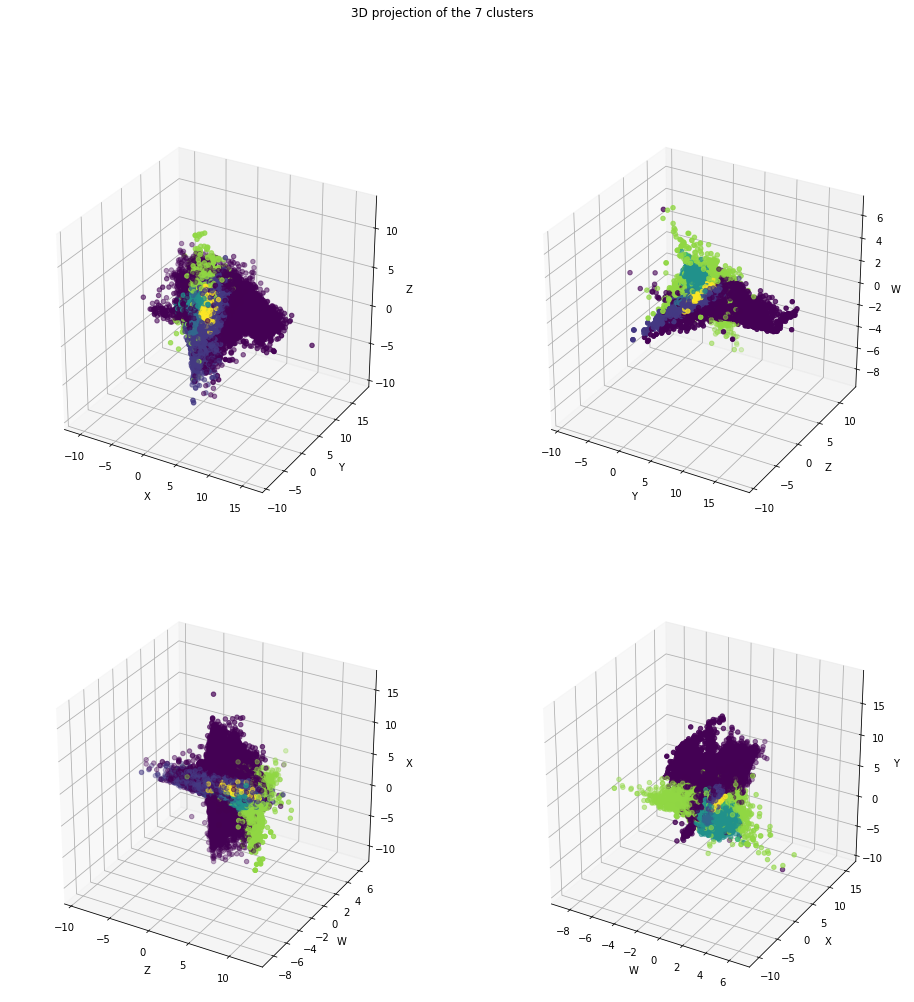

In [19]:
fig= plt.figure(figsize=(16, 16))
fig.suptitle('3D projection of the 7 clusters')

ax1= fig.add_subplot(2,2,1, projection= '3d')
ax1.scatter(fv.X, fv.Y, fv.Z, c=pv.prediction, marker='o')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(2,2,2, projection='3d')
ax2.scatter(fv.Y, fv.Z, fv.W, c=pv.prediction, marker='o')
ax2.set_xlabel('Y')
ax2.set_ylabel('Z')
ax2.set_zlabel('W')

ax3 = fig.add_subplot(2,2,3, projection='3d')
ax3.scatter(fv.Z, fv.W, fv.X, c=pv.prediction, marker='o')
ax3.set_xlabel('Z')
ax3.set_ylabel('W')
ax3.set_zlabel('X')

ax4 = fig.add_subplot(2,2,4, projection='3d')
ax4.scatter(fv.W, fv.X, fv.Y, c=pv.prediction, marker='o')
ax4.set_xlabel('W')
ax4.set_ylabel('X')
ax4.set_zlabel('Y')

plt.show()

-----------

### Step 3. Speed-up analysis

#### Start an Spark cluster of 4 nodes, repeat the tasks in step 3, and record runtime of training GMM model.

In [4]:
df = spark.read.csv("s3://csed516/smalldatasetspark", header = "false", inferSchema = "true")
assembler = VectorAssembler(inputCols=["_c1", "_c2", "_c3", "_c4"], outputCol="features")
output = assembler.transform(df)
output = output.select("_c0", "features")

In [5]:
start_time_4_node = time.time()
gmm = GaussianMixture(k=7, tol=0.001, maxIter=10, seed=10)
model = gmm.fit(output)
run_time_4_node = time.time() - start_time_4_node
print("4 nodes runtime: %s seconds" % round(run_time_4_node, 2))

4 nodes runtime: 41.31 seconds


#### Start a Spark cluster of 8 nodes, repeat the tasks in step 3, and record runtime of training GMM model.

In [9]:
df = spark.read.csv("s3://csed516/smalldatasetspark", header = "false", inferSchema = "true")
assembler = VectorAssembler(inputCols=["_c1", "_c2", "_c3", "_c4"], outputCol="features")
output = assembler.transform(df)
output = output.select("_c0", "features")

In [10]:
start_time_8_node = time.time()
gmm = GaussianMixture(k=7, tol=0.001, maxIter=10, seed=10)
model = gmm.fit(output)
run_time_8_node = time.time() - start_time_8_node
print("8 nodes runtime: %s seconds" % round(run_time_8_node, 2))

8 nodes runtime: 37.76 seconds


#### How does runtime vary with the number of instances/nodes in the Spark cluster?

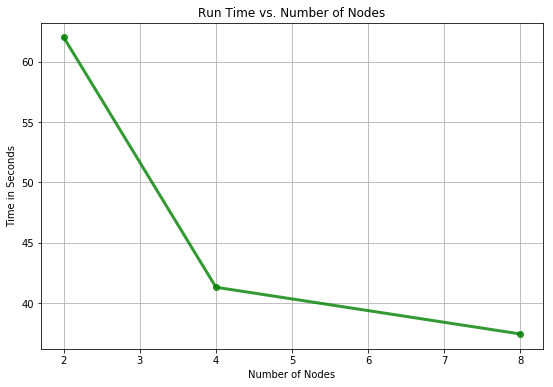

In [8]:
fig = plt.figure(figsize=(9, 6))
plt.grid(True)

plt.plot([2, 4, 8], [62.0, 41.31, 37.76],\
         color = "green", alpha = 0.8, linewidth = 3, marker='o')

plt.legend(loc=2)
plt.xlabel("Number of Nodes")
plt.ylabel("Time in Seconds")
plt.title("Run Time vs. Number of Nodes")

plt.show()

#### Execution time: 62.0s (2 nodes) vs. 41.31s (4 nodes) vs. 37.76s (8 nodes)
The runtime decreased by 1/3 when increasing the number of nodes from 2 to 4. However, the slope of decreasing on runtime appreared to be less steeper after 4 nodes.

-----------

### Step 4. Scale-up analysis

#### Read CSV file into dataframe.

In [21]:
df_large = spark.read.csv("s3://csed516/largerdatasetspark/wise-colors-15-20-subset1.csv", header = "false",\
                          inferSchema = "true")
df.take(4)

[Row(_c0=1237661088029606015, _c1=0.575469, _c2=1.37509, _c3=1.941, _c4=-0.0360003),
 Row(_c0=1237661088024822536, _c1=1.00735, _c2=3.06909, _c3=3.701, _c4=-0.059),
 Row(_c0=1237661088024822606, _c1=1.4684, _c2=2.50721, _c3=3.184, _c4=-0.105),
 Row(_c0=1237661088024887302, _c1=0.761256, _c2=1.44754, _c3=1.356, _c4=-0.0959997)]

#### Convert dataframe into libsvm format dataframe.

In [22]:
assembler = VectorAssembler(inputCols=["_c1", "_c2", "_c3", "_c4"], outputCol="features")
output_large_1 = assembler.transform(df_large)
output_large_1 = output_large_1.select("_c0", "features")
output_large_1.take(4)

[Row(_c0=1237661088029606015, features=DenseVector([0.5755, 1.3751, 1.941, -0.036])),
 Row(_c0=1237661088024822536, features=DenseVector([1.0073, 3.0691, 3.701, -0.059])),
 Row(_c0=1237661088024822606, features=DenseVector([1.4684, 2.5072, 3.184, -0.105])),
 Row(_c0=1237661088024887302, features=DenseVector([0.7613, 1.4475, 1.356, -0.096]))]

In [23]:
print("Number of partitions of the libsvm format dataframe of the large data set:")
output_large_1.rdd.getNumPartitions()

Number of partitions of the libsvm format dataframe of the large data set:


8

In [24]:
start_time_large = time.time()
gmm = GaussianMixture(k=7, tol=0.001, maxIter=10, seed=10)
model_1 = gmm.fit(output_large_1)
run_time_large = time.time() - start_time_large
print("Large data set runtime: %s seconds" % round(run_time_large, 2))

Large data set runtime: 152.45 seconds


In [25]:
print("Means of the 7 components: ")
model_1.gaussiansDF.select('mean').take(7)

Means of the 7 components: 


[Row(mean=DenseVector([1.6104, 2.2945, 2.0566, -0.0256])),
 Row(mean=DenseVector([1.4469, 2.2812, 3.2187, -0.1331])),
 Row(mean=DenseVector([1.9906, 5.2308, 1.4457, -0.0131])),
 Row(mean=DenseVector([1.1642, 3.3516, 3.3221, 0.3043])),
 Row(mean=DenseVector([1.6276, 2.8737, 2.2822, 0.0143])),
 Row(mean=DenseVector([1.8369, 2.6013, 3.4341, 0.3009])),
 Row(mean=DenseVector([0.8261, 1.7257, 3.4881, 0.3361]))]

In [26]:
print("Covariance matrices of the 7 components: ")
model_1.gaussiansDF.select('cov').take(7)

Covariance matrices of the 7 components: 


[Row(cov=DenseMatrix(4, 4, [0.6094, 0.4822, -0.0389, 0.0476, 0.4822, 0.4206, -0.0326, 0.037, -0.0389, -0.0326, 0.6381, -0.0129, 0.0476, 0.037, -0.0129, 0.0129], False)),
 Row(cov=DenseMatrix(4, 4, [0.4401, 0.359, 0.1057, -0.0008, 0.359, 0.3952, 0.0933, 0.0027, 0.1057, 0.0933, 0.4836, -0.0743, -0.0008, 0.0027, -0.0743, 0.0596], False)),
 Row(cov=DenseMatrix(4, 4, [6.3074, -0.7438, 0.707, 0.0534, -0.7438, 3.5454, -0.3937, 0.0329, 0.707, -0.3937, 1.5354, 0.0024, 0.0534, 0.0329, 0.0024, 0.0297], False)),
 Row(cov=DenseMatrix(4, 4, [0.5394, -0.002, 0.19, -0.1167, -0.002, 0.8444, -0.2684, -0.0328, 0.19, -0.2684, 1.4158, -0.3166, -0.1167, -0.0328, -0.3166, 0.5681], False)),
 Row(cov=DenseMatrix(4, 4, [0.5671, 0.432, -0.0125, 0.0219, 0.432, 0.6921, 0.0102, 0.0147, -0.0125, 0.0102, 1.8204, 0.0262, 0.0219, 0.0147, 0.0262, 0.0209], False)),
 Row(cov=DenseMatrix(4, 4, [0.3898, 0.2294, -0.1148, -0.0279, 0.2294, 0.3003, -0.1151, -0.0596, -0.1148, -0.1151, 0.2744, 0.0299, -0.0279, -0.0596, 0.0299, 0.

In [27]:
print("Weights of the 7 components: ")
model_1.weights

Weights of the 7 components: 


[0.32091916287278643,
 0.18050937093726185,
 0.022878363584169913,
 0.03283508548670403,
 0.09555703426344302,
 0.19363789672947854,
 0.15366308612615623]

#### Execution time: 152.45s (large data set) vs. 62.0 (small data set)
The number of rows in the large data set is almost 8 times of the rows in the small data set. The runtime of GMM model with a maximum interation time 10 on the large data set is only ~2.5 times the runtime on small data set.
#### Number of partitions: 8 (large data set) vs. 4 (small data set)
The numbers of partiotions of rdd files of the large and small data sets are 8 and 4 respectively.
#### Comparison of components:
The components get through running GMM on large and small data sets seems to be very similar. A corresponding cluster to any cluster from the small data set can be found in the clustering results from large data set.

--------------------------------------------------------

### Step 5. Data management and analysis

#### a. Generate different-size subsets of the larger dataset, run GMM algorithm, and record runtime.

#### Subset 1, filter the data set on the condition that the value on X dimension is larger than on Y dimension.

In [30]:
df_large_2 = df_large.filter(df_large["_c1"] > df_large["_c2"])
print(df_large_2.count())
print(df_large.count())

120848
15575834


In [31]:
assembler = VectorAssembler(inputCols=["_c1", "_c2", "_c3", "_c4"], outputCol="features")
output_large_2 = assembler.transform(df_large_2)
output_large_2 = output_large_2.select("_c0", "features")
output_large_2.take(4)

[Row(_c0=1237661087488672510, features=DenseVector([2.6761, 2.6631, 2.848, 0.409])),
 Row(_c0=1237661087491883523, features=DenseVector([2.3788, 2.332, 3.346, 0.684])),
 Row(_c0=1237661088029933917, features=DenseVector([2.6009, 2.4269, 3.655, 0.215])),
 Row(_c0=1237661087498240388, features=DenseVector([2.7465, 2.451, 3.645, 0.713]))]

In [33]:
start_time_large_2 = time.time()
gmm = GaussianMixture(k=7, tol=0.001, maxIter=10, seed=10)
model_2 = gmm.fit(output_large_2)
run_time_large_2 = time.time() - start_time_large_2
print("Subset(120848 out of 15575834 rows) of large data set runtime: %s seconds" % round(run_time_large_2, 2))

Subset(120848 out of 15575834 rows) of large data set runtime: 21.9 seconds


In [34]:
print("Means of the 7 components: ")
model_2.gaussiansDF.select('mean').take(7)

Means of the 7 components: 


[Row(mean=DenseVector([1.9259, 0.6548, 3.6982, 2.1707])),
 Row(mean=DenseVector([7.5618, 4.7026, 1.4692, 0.0019])),
 Row(mean=DenseVector([1.8853, 1.7541, 3.7117, 0.864])),
 Row(mean=DenseVector([2.5718, 2.4439, 3.5268, 0.4679])),
 Row(mean=DenseVector([2.7101, 2.3749, 2.5803, 0.2628])),
 Row(mean=DenseVector([3.1249, 1.5735, 0.4179, -0.0439])),
 Row(mean=DenseVector([5.273, 4.2007, 3.1684, -0.0249]))]

In [35]:
print("Covariance matrices of the 7 components: ")
model_2.gaussiansDF.select('cov').take(7)

Covariance matrices of the 7 components: 


[Row(cov=DenseMatrix(4, 4, [0.9794, 0.9236, -0.0832, -0.7052, 0.9236, 2.1692, -0.0697, -1.6123, -0.0832, -0.0697, 0.5948, 0.051, -0.7052, -1.6123, 0.051, 1.8415], False)),
 Row(cov=DenseMatrix(4, 4, [1.8399, 0.2957, -0.8585, -0.0417, 0.2957, 2.7319, -1.0018, -0.0405, -0.8585, -1.0018, 1.6706, 0.0418, -0.0417, -0.0405, 0.0418, 0.0263], False)),
 Row(cov=DenseMatrix(4, 4, [0.4429, 0.4314, -0.036, -0.1179, 0.4314, 0.4415, -0.0351, -0.1292, -0.036, -0.0351, 0.1619, -0.0319, -0.1179, -0.1292, -0.0319, 0.2206], False)),
 Row(cov=DenseMatrix(4, 4, [0.12, 0.1149, -0.1127, -0.0716, 0.1149, 0.1377, -0.1208, -0.0845, -0.1127, -0.1208, 0.3748, 0.0239, -0.0716, -0.0845, 0.0239, 0.1503], False)),
 Row(cov=DenseMatrix(4, 4, [1.2127, 1.0662, -0.2861, -0.1232, 1.0662, 1.0733, -0.3458, -0.1152, -0.2861, -0.3458, 1.8153, -0.0843, -0.1232, -0.1152, -0.0843, 0.1896], False)),
 Row(cov=DenseMatrix(4, 4, [1.3971, 0.3087, -0.0481, -0.0046, 0.3087, 0.6542, 0.0451, -0.0019, -0.0481, 0.0451, 0.4379, -0.0006, -0.

In [36]:
print("Weights of the 7 components: ")
model_2.weights

Weights of the 7 components: 


[0.012435236017650628,
 0.08489163671815132,
 0.442987107164916,
 0.2971472735172988,
 0.069128128444142,
 0.07189883662705447,
 0.02151178151078681]

#### Subset 2, select the rows with even IDs.

In [37]:
df_large_4 = df_large.filter(df_large["_c0"]%2 == 0)
print(df_large_4.count())
print(df_large.count())

7777292
15575834


In [39]:
assembler = VectorAssembler(inputCols=["_c1", "_c2", "_c3", "_c4"], outputCol="features")
output_large_4 = assembler.transform(df_large_4)
output_large_4 = output_large_4.select("_c0", "features")
output_large_4.take(4)

[Row(_c0=1237661088024822536, features=DenseVector([1.0073, 3.0691, 3.701, -0.059])),
 Row(_c0=1237661088024822606, features=DenseVector([1.4684, 2.5072, 3.184, -0.105])),
 Row(_c0=1237661088024887302, features=DenseVector([0.7613, 1.4475, 1.356, -0.096])),
 Row(_c0=1237661088024887822, features=DenseVector([1.0417, 1.4749, 2.867, 0.212]))]

In [44]:
start_time_large_4 = time.time()
gmm = GaussianMixture(k=7, tol=0.001, maxIter=10, seed=10)
model_4 = gmm.fit(output_large_4)
run_time_large_4 = time.time() - start_time_large_4
print("Subset(7777292/15575834 rows) of large data set runtime: %s seconds" % round(run_time_large_4, 2))

Subset(7777292/15575834 rows) of large data set runtime: 99.37 seconds


In [41]:
print("Means of the 7 components: ")
model_4.gaussiansDF.select('mean').take(7)

Means of the 7 components: 


[Row(mean=DenseVector([1.942, 3.3486, 2.3581, -0.0665])),
 Row(mean=DenseVector([2.399, 2.9501, 2.521, 0.0724])),
 Row(mean=DenseVector([2.0262, 4.9002, 1.327, 0.0088])),
 Row(mean=DenseVector([1.4445, 2.2111, 3.6164, 0.3268])),
 Row(mean=DenseVector([1.0899, 2.9403, 3.6205, 0.3141])),
 Row(mean=DenseVector([1.0714, 1.8889, 2.1533, -0.0696])),
 Row(mean=DenseVector([0.8858, 1.9121, 3.2196, 0.0067]))]

In [42]:
print("Covariance matrices of the 7 components: ")
model_4.gaussiansDF.select('cov').take(7)

Covariance matrices of the 7 components: 


[Row(cov=DenseMatrix(4, 4, [0.4658, 0.1472, 0.1532, 0.0079, 0.1472, 0.4378, 0.1518, 0.018, 0.1532, 0.1518, 1.5189, -0.0838, 0.0079, 0.018, -0.0838, 0.0296], False)),
 Row(cov=DenseMatrix(4, 4, [0.1541, 0.0963, -0.0819, 0.0143, 0.0963, 0.1351, -0.0459, 0.0089, -0.0819, -0.0459, 0.9017, -0.003, 0.0143, 0.0089, -0.003, 0.0243], False)),
 Row(cov=DenseMatrix(4, 4, [5.4035, -0.4103, 0.7386, 0.0548, -0.4103, 3.616, 0.1319, 0.0097, 0.7386, 0.1319, 2.1898, 0.0415, 0.0548, 0.0097, 0.0415, 0.0372], False)),
 Row(cov=DenseMatrix(4, 4, [0.3859, 0.2999, -0.0407, -0.0677, 0.2999, 0.376, -0.046, -0.103, -0.0407, -0.046, 0.1807, -0.0142, -0.0677, -0.103, -0.0142, 0.2206], False)),
 Row(cov=DenseMatrix(4, 4, [0.3421, -0.0277, 0.1097, -0.1105, -0.0277, 0.7117, -0.2426, 0.0465, 0.1097, -0.2426, 0.9191, -0.3247, -0.1105, 0.0465, -0.3247, 0.4667], False)),
 Row(cov=DenseMatrix(4, 4, [0.1753, 0.1504, -0.0471, -0.0003, 0.1504, 0.1762, -0.045, 0.0019, -0.0471, -0.045, 0.6396, -0.0127, -0.0003, 0.0019, -0.0127

In [43]:
print("Weights of the 7 components: ")
model_4.weights

Weights of the 7 components: 


[0.06742643036930648,
 0.2077321680125534,
 0.028619361224723455,
 0.25055167225727587,
 0.04239072622249076,
 0.2588192701347123,
 0.14446037177893767]

#### How does runtime vary with the number of instances/nodes in the Spark cluster?

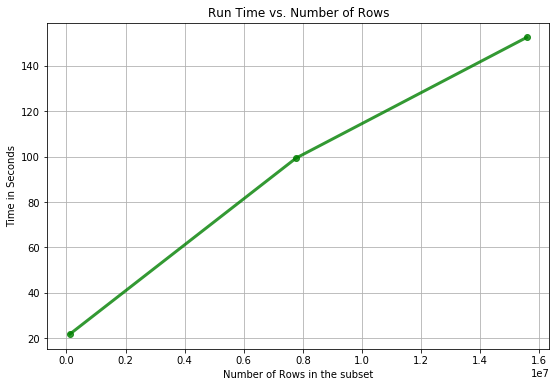

In [46]:
fig = plt.figure(figsize=(9, 6))
plt.grid(True)

plt.plot([120848, 7777292, 15575834], [run_time_large_2, run_time_large_4, run_time_large],\
         color = "green", alpha = 0.8, linewidth = 3, marker='o')

plt.legend(loc=2)
plt.xlabel("Number of Rows in the subset")
plt.ylabel("Time in Seconds")
plt.title("Run Time vs. Number of Rows")

plt.show()

#### Execution time:
As shown in the above plot, the runtime of training GMM model on subset or the original large data set is linearly correlated to the number of rows in the data.
#### Comparison of components:
Because of the differen logic of subsetting the data. It is found that the 7 components for subset 2 is much more similar to components for the original data, compare to subset 1. It is mostly because subset 2 is generated much more randomly by selecting the rows with even IDs while subset 1 is generated by filtering on the condition that the value on X dimension is larger than on Y dimension. The latter logic of subsetting the data changed the distribution of the training data significantly, thus affected the cluster shapes.

---

#### b. Run GMM using three out of four of the available dimensions and record runtime. Here I choose dimension X, Y, and Z.

In [47]:
assembler = VectorAssembler(inputCols=["_c1", "_c2", "_c3"], outputCol="features")
output_large_3 = assembler.transform(df_large)
output_large_3 = output_large_3.select("_c0", "features")
output_large_3.take(4)

[Row(_c0=1237661088029606015, features=DenseVector([0.5755, 1.3751, 1.941])),
 Row(_c0=1237661088024822536, features=DenseVector([1.0073, 3.0691, 3.701])),
 Row(_c0=1237661088024822606, features=DenseVector([1.4684, 2.5072, 3.184])),
 Row(_c0=1237661088024887302, features=DenseVector([0.7613, 1.4475, 1.356]))]

In [48]:
start_time_large_3 = time.time()
gmm = GaussianMixture(k=7, tol=0.001, maxIter=10, seed=10)
model_3 = gmm.fit(output_large_3)
run_time_large_3 = time.time() - start_time_large_3
print("Use X, Y, and Z dimenstions for clustering runtime: %s seconds" % round(run_time_large_3, 2))

Use X, Y, and Z dimenstions for clustering runtime: 186.64 seconds


In [49]:
print("Means of the 7 components: ")
model_3.gaussiansDF.select('mean').take(7)

Means of the 7 components: 


[Row(mean=DenseVector([1.0302, 1.8806, 2.6485])),
 Row(mean=DenseVector([2.0792, 4.8504, 1.629])),
 Row(mean=DenseVector([1.411, 2.3958, 2.0203])),
 Row(mean=DenseVector([1.4192, 3.2674, 3.0775])),
 Row(mean=DenseVector([0.767, 1.6324, 3.348])),
 Row(mean=DenseVector([2.3437, 2.9125, 2.4894])),
 Row(mean=DenseVector([1.6785, 2.5961, 3.5773]))]

In [50]:
print("Covariance matrices of the 7 components: ")
model_3.gaussiansDF.select('cov').take(7)

Covariance matrices of the 7 components: 


[Row(cov=DenseMatrix(3, 3, [0.1193, 0.1011, 0.0722, 0.1011, 0.1569, 0.0769, 0.0722, 0.0769, 0.785], False)),
 Row(cov=DenseMatrix(3, 3, [4.8731, -0.3533, 0.521, -0.3533, 3.1109, -0.3372, 0.521, -0.3372, 2.374], False)),
 Row(cov=DenseMatrix(3, 3, [0.2182, 0.1095, 0.1375, 0.1095, 0.2672, 0.1587, 0.1375, 0.1587, 1.3002], False)),
 Row(cov=DenseMatrix(3, 3, [0.4609, 0.0597, 0.0829, 0.0597, 0.593, -0.1886, 0.0829, -0.1886, 1.159], False)),
 Row(cov=DenseMatrix(3, 3, [0.0483, 0.0326, 0.0034, 0.0326, 0.1458, -0.02, 0.0034, -0.02, 0.3878], False)),
 Row(cov=DenseMatrix(3, 3, [0.1828, 0.1245, -0.0437, 0.1245, 0.1696, -0.0378, -0.0437, -0.0378, 1.0484], False)),
 Row(cov=DenseMatrix(3, 3, [0.3333, 0.1496, -0.0488, 0.1496, 0.298, -0.0781, -0.0488, -0.0781, 0.1504], False))]

In [51]:
print("Weights of the 7 components: ")
model_3.weights

Weights of the 7 components: 


[0.26346531285261215,
 0.03206658798127641,
 0.07654473537571908,
 0.05967453857369295,
 0.17084840218767275,
 0.25712807517785424,
 0.1402723478511724]

#### Execution time: 186.64s (3 dimenstions, large data set) vs. 152.45s (4 dimenstions, large data set)
The execution time did not decrease when decreasing the dimensions of the data set.
#### Comparison of components:
After cutting the dimension W from the data, we get components with three dimensions on X, Y, and Z. It is found that the coponents are still similar to the components got from four dimenstions if we only focus on the results on dimensions X, Y, and Z. 

Similar covariance matrices are found for the corresponding clusters, for instance, 
    
    covariance matrix of cluster one when training on four dimenstions:
    
    [6.3074, -0.7438, 0.707, 0.0534, 
    
     -0.7438, 3.5454, -0.3937, 0.0329, 
     
     0.707, -0.3937, 1.5354, 0.0024, 
     
     0.0534, 0.0329, 0.0024, 0.0297]
     
    Covariance matrix of cluster one when training on three dimenstions, X, Y, and Z:
     
     [4.8731, -0.3533, 0.521, 
     
      -0.3533, 3.1109, -0.3372, 
      
      0.521, -0.3372, 2.374]
      
The second matrix is close to a diagonal matrix and similar diagonal trend is observed when only looking at the X, Y, and Z dimensions on the first matrix.